<a href="https://colab.research.google.com/github/ankitgoelcmu/DeepLearning/blob/main/NanoGPT_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Architecture of GPT 2 Model:
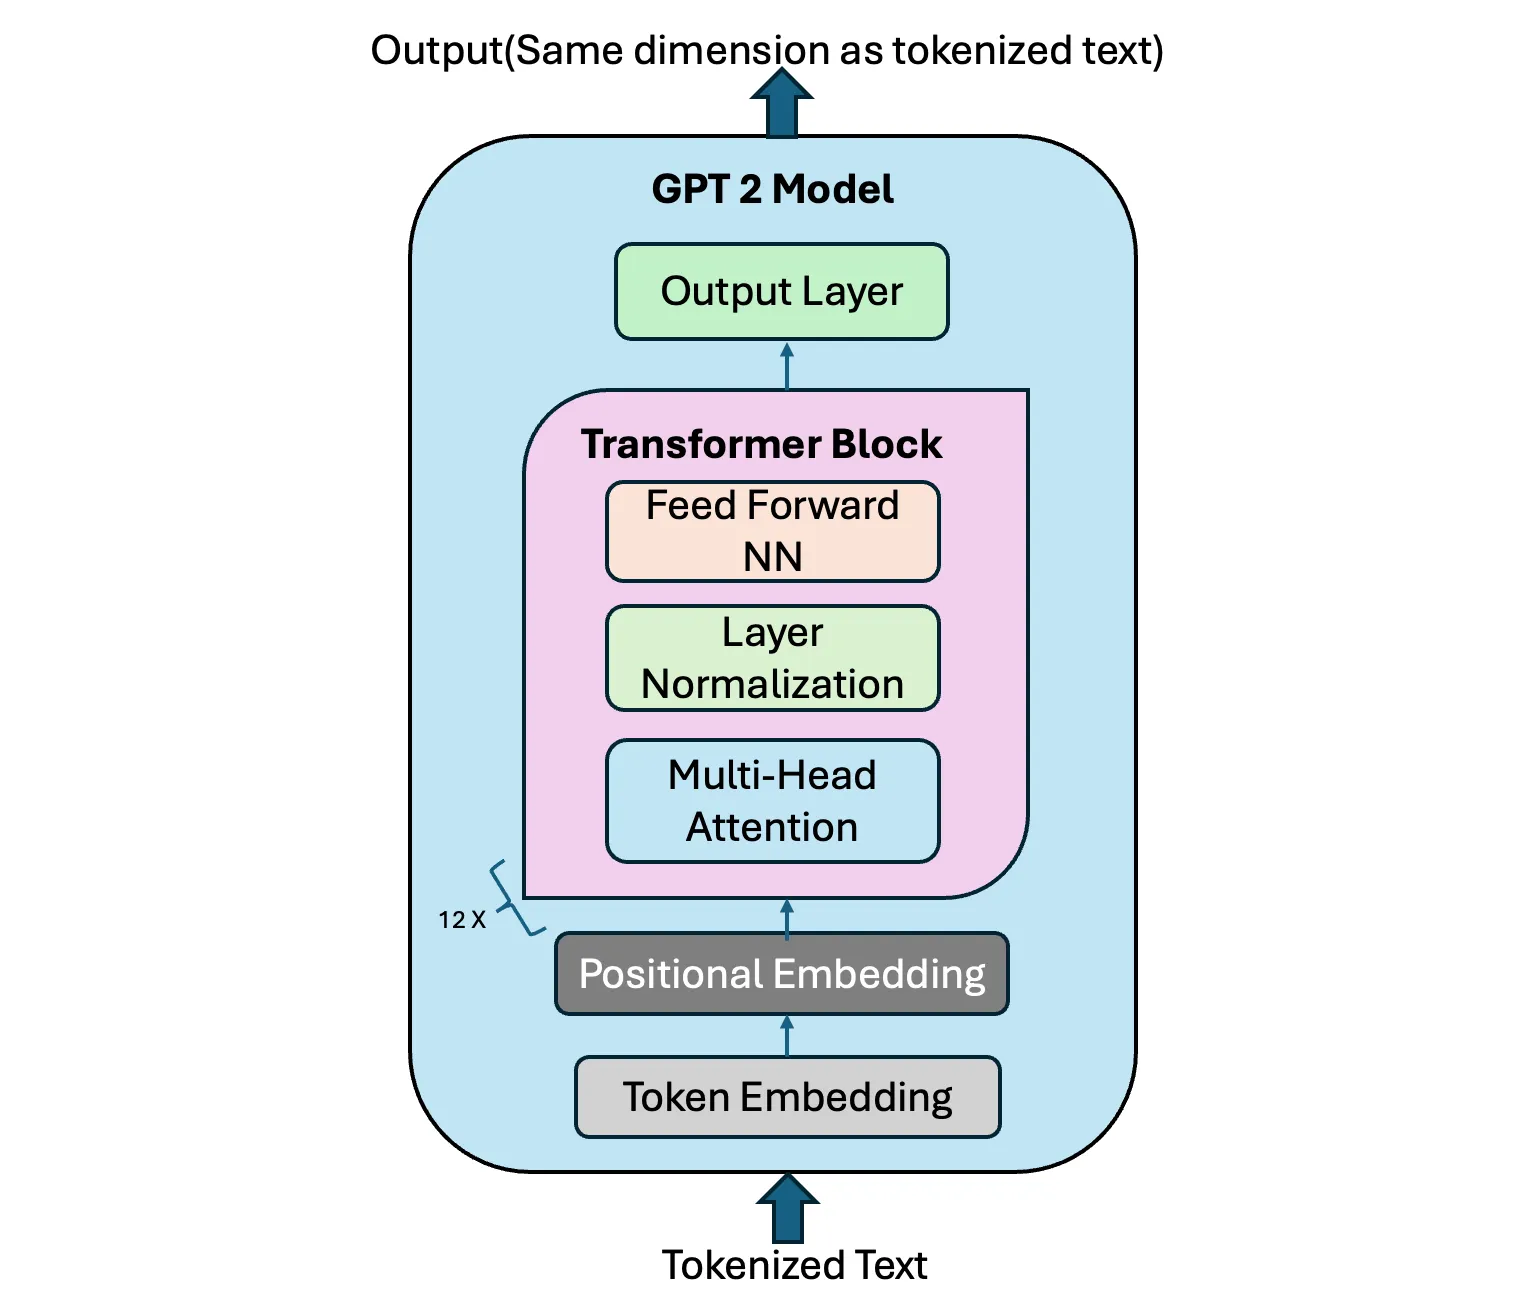

# Key Variables used in the model


1.   vocab_size: Vocabulary dize
2.   max_seq_len: max input token lngth
3.   embedding_dim: embedding size for input tokens
4.   num_heads: Number of attention heads in each T block
5.   num_layers: Number of Transformer Blocks
6.   mlp_size: Number of expanded neurons in mlp layer of Feed Forward NN
7.   dropout: dropout rate

Dropout is a regularization technique used to prevent overfitting in neural networks by randomly setting a fraction of model weights to zero during training. This encourages the model to learn more robust features and reduces dependency on specific neurons, helping the network generalize better to new, unseen data. During model inference, dropout is deactivated. This essentially means that we are using an ensemble of the trained subnetworks, which leads to a better model performance.

What are other regularization techniques ?


1.   Dropout
2.   Batch Normalization









In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init  # For trunc_normal
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#Step 1 = Define the `NanoGPT` Model based on above architecture and layers

In [3]:
import torch
import torch.nn as nn
import torch.nn.init as init  # For trunc_normal
import torch.nn.functional as F  # For loss


class NanoGPT(nn.Module):
  def __init__ (
      self,
      vocab_size: int = 50257,
      max_seq_len: int = 1024,
      embedding_dim: int = 384,
      num_heads: int = 2,   # Num of Attention Head
      num_layers: int = 2,  # Decoder Layers
      dropout: float = 0.1,
      mlp_size: int = 3072
  ):
      super().__init__()
      self.vocab_size = vocab_size
      self.max_seq_len = max_seq_len
      self.embedding_dim = embedding_dim
      self.num_heads = num_heads
      self.num_layers = num_layers

      #Learnable Token Embeddings
      #The torch.nn.Embedding layer in PyTorch functions as a learnable lookup table that maps discrete
      #integer indices (such as words in a vocabulary) into dense, continuous vectors of fixed size, known as embeddings
      self.token_embed = nn.Embedding(vocab_size, embedding_dim)
      # Optional: Init (uniform or normal; GPT uses trunc_normal)
      #Truncate means we cut the tails off . Say trunc_normal_(tensor, std=0.02, mean=0)
      #It pulls numbers from a normal bell with std 0.02 (tiny spread). But it rejects anything bigger than 2 times std
      init.trunc_normal_(self.token_embed.weight, std=0.02)  # Small random for stability

      # Learnable positional embeddings (GPT-2 style: absolute, trainable)
      self.pos_embed = nn.Parameter(torch.zeros(1, max_seq_len, embedding_dim))
      init.trunc_normal_(self.pos_embed, std=0.02) #Small random for stability

      #GPT 2 architecture calls out to add dropout after positional embedding so we will create the dropput layer
      #self.dropout = nn.Dropout(dropout)

      #For this initial version of we will use OOB Transformer Layer provided by PyTorch
      # Read more here -- https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html


    # Built-in TransformerDecoder (decoder-only, causal self-attention)
      self.transformer_layers = nn.TransformerDecoder(  # "TransformerDecoder" for decoder-only
          nn.TransformerDecoderLayer(  # Decoder layer prototype
              d_model=embedding_dim,
              nhead=num_heads,
              dim_feedforward=mlp_size,
              dropout=dropout,
              activation='gelu',
              batch_first=True,
              norm_first=False,  # Post-norm for GPT-2
          ),
          num_layers=num_layers,  # Stack num_layers decoder layers
      )

      # Final Output Layer: The final output layer in GPT-2 is responsible for generating predictions for the next token in the sequence.
      # Once the input passes through the stacked transformer blocks, the model uses the final output to predict the most likely next word.
      self.output_layer = nn.Linear(embedding_dim, vocab_size)
      self.output_layer.weight = self.token_embed.weight #Shared weights, use learned positional embeddings and weight tying between the input and output layers.

      # dropout layer for regualrization
      self.dropout = nn.Dropout(dropout)

  def forward (self,x):
    B, T = x.shape #Batch, Input Seq Length
    token_embed = self.token_embed(x) # [B, T, D]
    x = token_embed + self.pos_embed[:, :T, :]
    x = self.dropout(x)
    #TODO
    memory = torch.zeros(B, T, self.embedding_dim, device=x.device)  # Dummy memory for self-attn
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(T, device=x.device)  # Causal mask [T, T]
    x = self.transformer_layers(tgt=x, memory=memory, tgt_mask=tgt_mask)
    x = self.output_layer(x) #B,T,V
    return x

#Step 2: Instantiate the model and pass the sample random input and print out the output logit shape for a correspondng input

In [4]:
model = NanoGPT()
x = torch.randint(0, 50257, (2, 32))  # Dummy word/subword IDs [B=2, T=32]. This input means we are passing  batches =2, of input seq tokens of length 32
print(f"Input to the NanoGPT: {x}")
logits = model(x)
print(f"Input shape: {x.shape}, Logits shape: {logits.shape}")  # [2, 32] → [2, 32, 50257] (B, T,V)

Input to the NanoGPT: tensor([[49379,   132, 40058, 30763, 14987, 22436,  5144, 11168, 21588, 36306,
         47132, 19944, 34959, 24496, 36409, 43559, 18913, 46954, 48668, 26580,
          3696, 38185, 49664, 43060, 10488,  3520, 18139, 12668, 15326, 14320,
          5707, 21529],
        [49159, 21181, 48760, 30055, 40544, 37936,  9473, 10009, 46637, 14867,
         16713, 11703, 13746, 26471, 47310, 20507, 27081, 34439, 12706,  9355,
         15656, 28466, 17157, 12532, 40668, 35879, 33770, 43685, 18486, 41419,
          3278, 21675]])
Input shape: torch.Size([2, 32]), Logits shape: torch.Size([2, 32, 50257])


#Step 3: Lets print Summary of our NanoGPT model using `torchinfo`
## Explore following from Summary of mode:
1. Each Layer of NanoGPT
2. Input and output shapes of each layer
3. Total Params
4. Trainable params
5. Size of output model size (Estimated and pre-training)

In [5]:
!pip install -q torchinfo
from torchinfo import summary

# Print a summary of our NanoGPT model using torchinfo
summary(model=model,
        input_size=(2, 200), # B, T - batch=2, seq_len=200
        dtypes=[torch.long],
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
NanoGPT (NanoGPT)                                            [2, 200]             [2, 200, 50257]      --                   True
├─Embedding (token_embed)                                    [2, 200]             [2, 200, 384]        19,298,688           True
├─Dropout (dropout)                                          [2, 200, 384]        [2, 200, 384]        --                   --
├─TransformerDecoder (transformer_layers)                    --                   [2, 200, 384]        --                   True
│    └─ModuleList (layers)                                   --                   --                   --                   True
│    │    └─TransformerDecoderLayer (0)                      [2, 200, 384]        [2, 200, 384]        3,547,776            True
│    │    └─TransformerDecoderLayer (1)                      [2, 200, 384]        [2, 200, 384

# Step 4: Start preparing for training


---

- Install and setup Tokenizer (Byte Pair Encoding) [BPE](https://huggingface.co/learn/llm-course/en/chapter6/5)
- Data Loading - Create a custom class `Dataset` and use it for `DataLoader` to batchify the training data with `batch_size=32`
- Train the model with batchified data from `DataLoader`. More [info on DataLoader](https://docs.pytorch.org/docs/stable/data.html)
- Save the Model to the local using `torch.save` so we can load it later and explore.
- Load the saved model, print its summary and explore its parameters, layers, shapes
- Inference Inference Inference

## Step 4.1: Install & Setup Tokenizer

In [5]:
!pip install tiktoken
import tiktoken
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader, Dataset
import numpy as np
from itertools import islice  # For sampling text

# GPT-2 tokenizer (subword BPE)
enc = tiktoken.get_encoding("gpt2")
vocab_size = enc.n_vocab  # 50257
print(f"Vocab size: {vocab_size}")

Vocab size: 50257


##Step 4.2: Data Loading

Define your custom implementation of the `Dataset` base class.

Implement following:

1. `__init__`
2. `__getlen__`  = tells PyTorch/DataLoader how many examples (indices) are available: It should return the maximum valid idx where `__getitem__(idx)` succeeds without slicing beyond. The DataLoader uses this value to determine how many batches exist per epoch
3. `__getitem__` = to support the indexing such that `dataset[i]` can be used to get ith sample.


In [63]:
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken  # Assuming tiktoken is imported earlier for enc

# Load Shakespeare text from file (replace 'shakespeare.txt' with your actual file path if different)
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Full text should be ~1M chars → ~300k tokens (depending on tokenizer)
print(f"Raw text len: {len(text)}")

# Tokenize with GPT-2 BPE (subword for word-level)
tokens = enc.encode(text)
print(f"Tokens len: {len(tokens)}")  # e.g., ~300k tokens
print(f"Sample tokens: {tokens[:10]}")  # IDs like [464, 3188, 257, ...]

class GPTDataset(Dataset):
    def __init__(self, tokens, block_size=64):  # T=64 context
        self.tokens = tokens
        self.block_size = block_size

    def __len__(self):
        return len(self.tokens) - self.block_size  # For shifted targets

    def __getitem__(self, idx):
        chunk = self.tokens[idx:idx + self.block_size + 1]  # +1 for target shift
        x = torch.tensor(chunk[:-1], dtype=torch.long)  # Input [block_size]
        y = torch.tensor(chunk[1:], dtype=torch.long)   # Target [block_size]
        return x, y

# Dataset/Loader (adjust block_size/batch_size for your hardware; larger = better but more mem)
dataset = GPTDataset(tokens, block_size=64)
a,b = dataset[0]
print(len(a))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)  # Added num_workers for speed

# Sample batch
x, y = next(iter(dataloader))
print(f"x shape: {x.shape}, Sample: {x[0][:5]}...")  # [32, 64], first 5 IDs
print(f"y shape: {y.shape}, Sample: {y[0][:5]}...")  # Shifted
print(f"x Length: {len(x)}")
print(f"y Lngth: {len(y)}")



Raw text len: 5436475
Tokens len: 1836425
Sample tokens: [220, 3574, 37063, 301, 8109, 356, 6227, 2620, 11, 198]
64
x shape: torch.Size([32, 64]), Sample: tensor([20832, 17534, 27975, 11015, 26720])...
y shape: torch.Size([32, 64]), Sample: tensor([17534, 27975, 11015, 26720,  9348])...
x Length: 32
y Lngth: 32


##Step 4.3: Training Loop

In [12]:
import torch.optim as optim
import torch.nn as nn # Re-import nn for clarity, as it's used by CrossEntropyLoss

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = optim.AdamW(model.parameters(), lr=6e-4)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 2  # Demo
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)  # [B, T, vocab]
        #Why Flatten? Cross Entropy expects 2D logits
        #cross_entropy(logits.view(-1, V), y.view(-1)) expects flattened [B*(T-1), V] logits vs. [B*(T-1)] targets.
        loss = loss_fn(logits.reshape(-1, vocab_size), y.reshape(-1))  # Flatten for loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")

Epoch 1: Loss 1.9241
Epoch 2: Loss 1.2252


## Step 4.4 Save the Trained Model

In [25]:
import torch

# Save after training (e.g., at end of epochs loop)
torch.save({
    'model_state_dict': model.state_dict(),  # Learned weights
    'optimizer_state_dict': optimizer.state_dict(),  # For resuming
    'vocab_size': vocab_size,  # Metadata for reload
    'block_size': 64,  # From dataset
    'final_loss': avg_loss,  # Last epoch loss
    'num_epochs_trained': num_epochs,
}, 'nano_gpt_shakespeare.pth')

print("Model saved to 'nano_gpt_shakespeare.pth'!")

Model saved to 'nano_gpt_shakespeare.pth'!


## Step 4.5 Print the Model Structure (Part of Model Exploration)

In [42]:
print(model)

NanoGPT(
  (token_embed): Embedding(50257, 384)
  (transformer_layers): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
        (linear1): Linear(in_features=384, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=384, bias=True)
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (dropout3): Dropo

## Step 4.5 Detailed Summary with TorchInfo (Part of Model Exploration)

In [41]:
!pip install torchinfo  # If not installed
from torchinfo import summary

summary(model, input_size=(1, 64), dtypes=[torch.long],  # Dummy input [B=1, T=64]
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
NanoGPT                                       [1, 64]                   [1, 64, 50257]            --                        True
├─Embedding: 1-1                              [1, 64]                   [1, 64, 384]              19,298,688                True
├─Dropout: 1-2                                [1, 64, 384]              [1, 64, 384]              --                        --
├─TransformerDecoder: 1-3                     --                        [1, 64, 384]              --                        True
│    └─ModuleList: 2-1                        --                        --                        --                        True
│    │    └─TransformerDecoderLayer: 3-1      [1, 64, 384]              [1, 64, 384]              3,547,776                 True
│    │    └─TransformerDecoderLayer: 3-2      [1, 64, 384]              [1, 64, 384]          

## Step 4.5 Downloading the Model `nano_gpt_shakespeare.pth` to the local for later use

In [27]:
from google.colab import files

files.download('nano_gpt_shakespeare.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 4.6 Inferencing

In [32]:
import torch.nn.functional as F  # For softmax
import tiktoken  # Your tokenizer (enc from training)

@torch.no_grad()  # Disable gradients for speed/memory
def generate(model, prompt: str, max_new_tokens: int = 100, temperature: float = 0.8, top_k: int = 50):
    """
    Generate text autoregressively with your trained NanoGPT.

    Args:
        model: Trained NanoGPT instance.
        prompt: Starting text (str, e.g., "To be or not to").
        max_new_tokens: Max additional tokens to generate.
        temperature: Randomness (0.8=balanced; <1=greedy, >1=creative).
        top_k: Limit sampling to top-k most likely tokens.

    Returns:
        str: Generated continuation (new text only).
    """
    model.eval()  # Eval mode

    # Get model's device dynamically
    device = next(model.parameters()).device

    # Encode prompt to token IDs
    tokens = torch.tensor([enc.encode(prompt)], dtype=torch.long, device=device)  # [1, prompt_T]

    for _ in range(max_new_tokens):
        # Forward: Full logits [1, current_T, vocab] (no slice for gen)
        logits = model(tokens)  # [1, current_T, vocab_size]

        # Sample from LAST position
        next_logits = logits[0, -1, :] / temperature  # [vocab_size]

        # Top-k filtering (optional)
        if top_k is not None:
            v, _ = torch.topk(next_logits, min(top_k, next_logits.size(0)))
            next_logits[next_logits < v[-1]] = -float('Inf')

        # Sample next token
        probs = F.softmax(next_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append
        tokens = torch.cat((tokens, next_token.unsqueeze(0)), dim=1)

    # Decode (trim prompt)
    full_text = enc.decode(tokens[0].tolist())
    generated = full_text[len(enc.encode(prompt)):]

    return generated

# Test it (after model.to(device) and model.eval())
prompt = "To be or not to"
generated = generate(model, prompt, max_new_tokens=50, temperature=0.8)
print(f"Prompt: '{prompt}'\nGenerated: {generated}")

Prompt: 'To be or not to'
Generated:  or not to a fool. I have you
     have seen more years, sir, by me out of prison.
  DUKE SENIOR. Come, we will consider of this further time;
    You shall be conducted.


In [35]:
prompt = "Hows your mummy doing"
generated = generate(model, prompt, max_new_tokens=50, temperature=0.8)
print(f"Prompt: '{prompt}'\nGenerated: {generated}")

Prompt: 'Hows your mummy doing'
Generated: your mummy doing.
  POSTHUMUS. Of late days upon that I could free
    The leading of your best report
    That I have seen him.
  KING. Take it, and away.
   


## Step 4.7 [[Bonus]] Token Embeddings t-SNE Plot. Motivation from [here](https://medium.com/@madhugraj/explainability-for-text-data-3d-visualization-of-token-embeddings-using-pca-t-sne-and-umap-8da33602615b)

First 5 token embeddings (5x5 slice):
[[-0.05145643  0.04720125  0.09195571 -0.12340873 -0.07108574]
 [-0.0113081  -0.18598832 -0.02092859  0.14467752  0.23572487]
 [ 0.08634406 -0.04865678  0.08140871  0.1198451   0.06892359]
 [ 0.08259422 -0.0536015   0.06656058  0.12642205  0.07252014]
 [ 0.0908791  -0.04287362  0.06692249  0.12335989  0.08022664]]


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 14 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 15 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 16 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 17 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 18 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127 () missing from font(s) DejaVu San

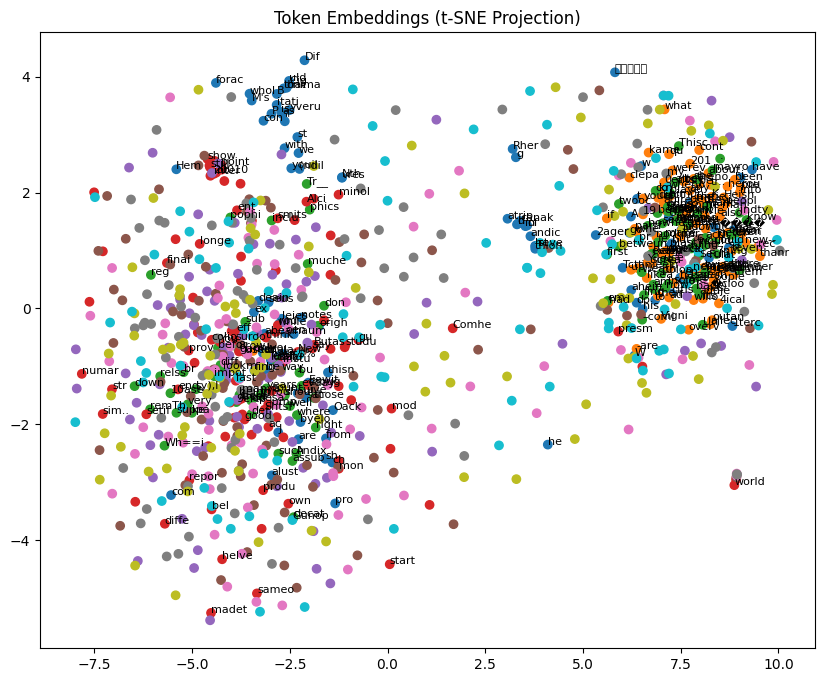

In [57]:
# Embeddings matrix [vocab, D]
embed = model.token_embed.weight.detach().cpu().numpy()

# Sample: Embeddings for first 5 tokens (decode IDs if you have enc)
print("First 5 token embeddings (5x5 slice):")
print(embed[:5, :5])

# Plot 2D projection (t-SNE for top 100 tokens)
from sklearn.manifold import TSNE
import tiktoken  # enc for decoding

enc = tiktoken.get_encoding("gpt2")
sample_ids = np.arange(1000)  # First 100 tokens
sample_embed = embed[sample_ids]

tsne = TSNE(n_components=2, random_state=42)
embed_2d = tsne.fit_transform(sample_embed)

plt.figure(figsize=(10, 8))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c=sample_ids, cmap='tab10')
for i, txt in enumerate(enc.decode(sample_ids).split()):  # Rough labels
    plt.annotate(txt[:5], (embed_2d[i, 0], embed_2d[i, 1]), fontsize=8)
plt.title('Token Embeddings (t-SNE Projection)')
plt.show()